# Laura Tigchelaar (s1013029) - Jelmer Jansen (s4480848)

Import the necessary packages. This notebook will only run properly when utils.py from Assignment 1 is in the same folder, since it needs the get_MNIST() function and the RandomIterator class. 

In [21]:
import chainer.functions as F
import chainer.links as L
from chainer import Link, Chain, ChainList, report, iterators, optimizers
import matplotlib.pyplot as plt
import math
import random
from utils import *

Define a generator neural network which can generate MNIST data of class zero when given random noise as input. 

In [22]:
class Generator(Chain):
    def __init__(self, n_units):
        super(Generator, self).__init__()
        self.mnist_dim = 28
        self.n_units = n_units
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(n_units * self.mnist_dim **2)  # n_in -> n_units        INPUT LAYER
            self.l2 = L.BatchNormalization(n_units * self.mnist_dim ** 2)    # n_units -> n_out       BATCH NORMALIZATION
            self.l3 = L.Deconvolution2D(in_channels=n_units, out_channels=1, ksize=3, stride=1,pad=1,outsize=(28,28))                   #  DECONVOLUTION

    def __call__(self, x):
        h1 = self.l1(x)
        h2 = F.relu(self.l2(h1))
        h = F.reshape(h2, [-1,self.n_units,self.mnist_dim,self.mnist_dim])
        y = F.sigmoid(self.l3(h))
        return y

Define a discriminator neural network which outputs 1 when given real MNIST data and 0 when given fake data created by the generator network. 

In [23]:
class Discriminator(Chain):
    def __init__(self, n_units):
        super(Discriminator, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l2 = L.Convolution2D(in_channels=None, out_channels=n_units,ksize=3,stride=1)  # n_units -> n_units  CONVOLUTIONAL LAYER
            self.l3 = L.Linear(None, 1)    # n_units -> n_out

    def __call__(self, x):
        h2 = F.relu(self.l2(x))
        y = F.squeeze(self.l3(h2))
        return y

Create some helper functions to make the above networks run properly. The function **randomsample()** will return an array of random numbers of _size_ times _batch_size_. The **plot_loss()** function plots the loss of both networks, which is given by the input as a double list. The **showImages()** function will print 10 MNIST images created by the generator network. 

In [24]:
def randomsample(size,batch_size):
    return np.random.uniform(-1.0,1.0,[batch_size,size]).astype('float32')

def plot_loss(loss,epoch):
    plt.plot(np.array(range(1, epoch + 1)), np.array(loss[0]), label='Discriminator Loss')
    plt.plot(np.array(range(1, epoch + 1)), np.array(loss[1]), label='Generator Loss')
    plt.legend()
    plt.show()

def showImages(gen):
    f,axes = plt.subplots(2,5)
    for i in range(0,10):
        if(i % 2 == 0):
            x = 0
        else:
            x = 1
        y = int(round(i/2,0))
        noise = randomsample(20, 1)
        image = gen(noise)
        axes[x][y].imshow(np.reshape(image.data[:,], (28, 28), order='F'))
    plt.show()

Define a function which runs both networks for a certain number of epochs. For each epoch, this function takes _k_ batches from the data and lets the discriminator compare these to batches of data created by the generator. The loss is then calculated with a sigmoid cross entropy function, and used to update the weights of the discriminator network through the _backward()_ and _update()_ functions. 

Then the generator network is updated by taking the probability that its images get recognized as fake data as the loss, which is then used to update the weights of the generator network through the _backward()_ and _update()_ functions. 

In [28]:
def run_network(epoch,batch_size,gen,dis,iterator,n_units,g_optimizer,d_optimizer):
    losses = [[],[]]
    for i in range(0,epoch):
        #for j in range (0,batch_size) THEY USED K=1 IN THE PAPER SO SO DO WE
        
        batch = iterator.next()
        dis.cleargrads(); gen.cleargrads()
        noise = randomsample(20,batch_size)
        g_sample = gen(noise)
        disc_gen = dis(g_sample)
        disc_data = dis(np.reshape(batch,(batch_size,1,28,28),order='F'))
        softmax1 = F.sigmoid_cross_entropy(disc_gen,np.zeros(batch_size).astype('int32'))
        softmax2 = F.sigmoid_cross_entropy(disc_data,np.ones(batch_size).astype('int32'))
        loss = softmax1 + softmax2
        loss.backward()
        d_optimizer.update()
        losses[0].append(loss.data)

        noise = randomsample(20, batch_size)
        gn = gen(noise)
        gloss = F.sigmoid_cross_entropy(disc_gen,np.ones(batch_size).astype('int32'))
        gloss.backward()
        g_optimizer.update()
        losses[1].append(gloss.data)
    return losses

Define the hyperparameters of the network, including the number of epochs, the batch size, and the number of hidden units per network layer. Also define the two networks themselves, an iterator for the train data and optimizers for both the networks. 

In [35]:
epoch = 2000
train_data, test_data = get_mnist(n_train=1000,n_test=100,with_label=False,classes=[0])
batch_size = 5
n_units = 10
gen = Generator(n_units)
dis = Discriminator(n_units)
iterator = iterators.SerialIterator(train_data,batch_size)
g_optimizer = optimizers.Adam()
g_optimizer.setup(gen)
d_optimizer = optimizers.Adam()
d_optimizer.setup(dis)

Run both adversarial networks, plot the loss and show 10 images created by the generator network. 

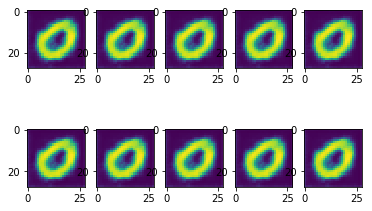

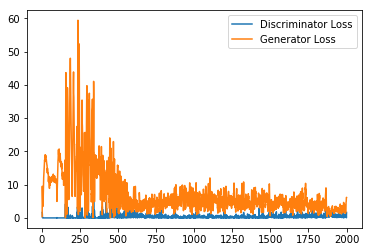

In [36]:
loss = run_network(epoch,batch_size,gen,dis,iterator,n_units,g_optimizer,d_optimizer)
showImages(gen)
plot_loss(loss,epoch)
